# Imports + config

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download --unzip misrakahmed/vegetable-image-dataset

 97% 519M/534M [00:04<00:00, 153MB/s]
100% 534M/534M [00:04<00:00, 126MB/s]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.math import argmax
from tensorflow.keras import layers
import numpy as np
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping

In [4]:
tf.config.experimental.list_physical_devices('GPU')[0]

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()[1].physical_device_desc

'device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7'

# Data loading

In [6]:
path = os.path.join(os.getcwd(), "Vegetable Images")
train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")
val_path = os.path.join(path, "validation")

In [7]:
data = []
for set_ in [test_path, train_path, val_path]:
  set_size = []
  for categ in os.listdir(set_):
    set_size.append(len(os.listdir(os.path.join(set_, categ))))
  data.append(set_size)

for d, set_ in zip(data, ["test", "train", "val"]):
  print(f"{set_} shape : {d}")

test shape : [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
train shape : [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
val shape : [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


In [8]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_path, image_size = (224, 224),
    label_mode="categorical")
test_data = tf.keras.utils.image_dataset_from_directory(
    test_path, image_size = (224, 224),
    label_mode="categorical")
val_data = tf.keras.utils.image_dataset_from_directory(
    val_path, image_size = (224, 224),
    label_mode="categorical")

class_names = train_data.class_names

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


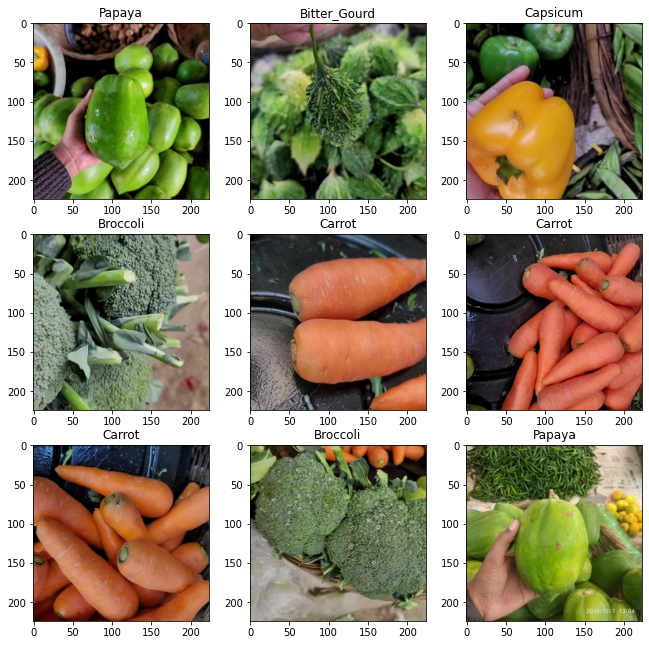

In [9]:
plt.figure(figsize = (11, 11))
for img, labels in train_data.take(1):
  for i in range(9):
    label = class_names[argmax(labels[i])]
    plt.subplot(3, 3, i+1)
    plt.title(label)
    plt.imshow(img[i].numpy().astype("uint8"))

# Modeling functions

In [10]:
def plot_lr_score(history, model, test_data, class_names):
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history["loss"], label="train_loss")
  plt.plot(history.history["val_loss"], label="val_loss")
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(history.history["accuracy"], label="train_accuracy")
  plt.plot(history.history["val_accuracy"], label="val_accuracy")
  plt.legend()
  # y_pred = tf.argmax(np.round(model.predict(X_test)), axis=1)
  # y_true = tf.argmax(y_test, axis=1)
  # conf_mat = confusion_matrix(y_true, y_pred)
  # labels = ["black", "grizzly", "teddy"]
  # plt.subplot(2, 2, 3)
  # plt.title("Confusion Matrix")
  # sns.heatmap(conf_mat, annot=True, cmap="Blues", cbar=False, xticklabels=labels, yticklabels=labels)
  # ax = plt.subplot(2, 2, 3)
  loss, accuracy = model.evaluate(test_data, verbose=0)
  # plt.grid(False)
  # plt.axis("off")
  # ax.text(0, 0.95, "Loss : {}".format(np.round(loss, 5)), fontsize="large")
  # ax.text(0, 0.9, "Accuracy : {}".format(np.round(accuracy, 5)), fontsize="large")
  print("Loss : ", np.round(loss, 5))
  print("Accuracy : ", np.round(accuracy, 5))

In [11]:
def model_training(model, batch_size, epochs, learning_rate, patience):
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

  early_stop = EarlyStopping(
      monitor = "val_loss",
      min_delta = 0,
      patience = patience,
      verbose = 1,
      restore_best_weights = True
  )

  history = model.fit(
      train_data,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=val_data,
      callbacks=[early_stop])
  return history

# V 1.0

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(15, activation="softmax"),
    ]
)
print("Number of parameters :", model.count_params())

Number of parameters : 9737711


In [ ]:
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 0.00001
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

early_stop = EarlyStopping(
    monitor = "val_loss",
    min_delta = 0,
    patience = 5,
    verbose = 1,
    restore_best_weights = True
)

history = model.fit(
    train_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_data,
    callbacks=[early_stop])

Epoch 1/100
94/94 [==============================] - 33s 341ms/step - loss: 3.1941 - accuracy: 0.0703 - val_loss: 2.7000 - val_accuracy: 0.0657
Epoch 2/100
94/94 [==============================] - 32s 337ms/step - loss: 2.7715 - accuracy: 0.0797 - val_loss: 2.6564 - val_accuracy: 0.1167
Epoch 3/100
94/94 [==============================] - 32s 335ms/step - loss: 2.6931 - accuracy: 0.1020 - val_loss: 2.5665 - val_accuracy: 0.1573
Epoch 4/100
94/94 [==============================] - 32s 335ms/step - loss: 2.6128 - accuracy: 0.1223 - val_loss: 2.4453 - val_accuracy: 0.2073
Epoch 5/100
94/94 [==============================] - 32s 336ms/step - loss: 2.5366 - accuracy: 0.1423 - val_loss: 2.3164 - val_accuracy: 0.2623
Epoch 6/100
94/94 [==============================] - 32s 335ms/step - loss: 2.4355 - accuracy: 0.1857 - val_loss: 2.2061 - val_accuracy: 0.3547
Epoch 7/100
94/94 [==============================] - 32s 336ms/step - loss: 2.3464 - accuracy: 0.2097 - val_loss: 2.1129 - val_accuracy:

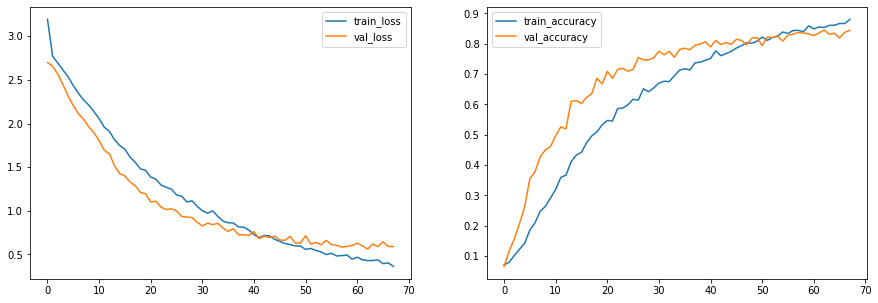

In [ ]:
plot_lr_score(history, model, test_data, class_names)

In [ ]:
model.save("/content/drive/MyDrive/vegetables/models/V_1_0.h5")

# V 1.1 - Tweaking Dropouts and Learning Rate

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(15, activation="softmax"),
    ]
)
print("Number of parameters :", model.count_params())

Number of parameters : 9737711


In [ ]:
batch_size = 128
epochs = 100
learning_rate = 0.00001
patience = 5

model_training(model, batch_size, epochs, learning_rate, patience)

Epoch 1/100
94/94 [==============================] - 33s 342ms/step - loss: 2.9754 - accuracy: 0.1000 - val_loss: 2.5894 - val_accuracy: 0.1247
Epoch 2/100
94/94 [==============================] - 32s 339ms/step - loss: 2.5566 - accuracy: 0.1590 - val_loss: 2.3524 - val_accuracy: 0.2280
Epoch 3/100
94/94 [==============================] - 32s 338ms/step - loss: 2.2953 - accuracy: 0.2430 - val_loss: 2.0914 - val_accuracy: 0.3237
Epoch 4/100
94/94 [==============================] - 32s 339ms/step - loss: 2.0705 - accuracy: 0.3180 - val_loss: 1.8527 - val_accuracy: 0.4137
Epoch 5/100
94/94 [==============================] - 32s 337ms/step - loss: 1.7787 - accuracy: 0.4287 - val_loss: 1.5598 - val_accuracy: 0.5057
Epoch 6/100
94/94 [==============================] - 32s 338ms/step - loss: 1.5078 - accuracy: 0.5170 - val_loss: 1.3745 - val_accuracy: 0.5723
Epoch 7/100
94/94 [==============================] - 32s 338ms/step - loss: 1.2858 - accuracy: 0.5937 - val_loss: 1.2902 - val_accuracy:

Loss :  0.61928
Accuracy :  0.8312


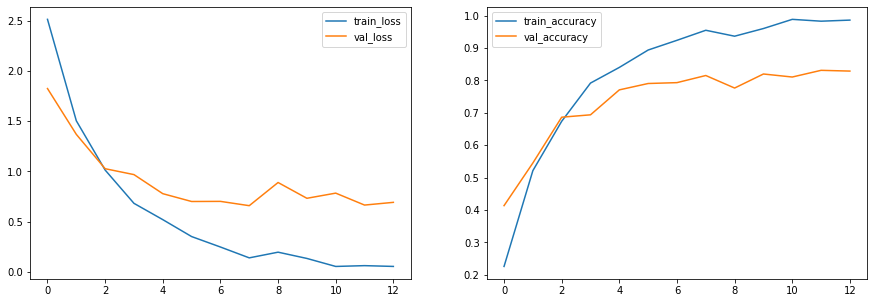

In [ ]:
plot_lr_score(history, model, test_data, class_names)

In [ ]:
model.save("/content/drive/MyDrive/vegetables/models/V_1_1.h5")

# Data Augmentation

In [ ]:
augment = keras.Sequential([
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomRotation(0.2),
])

Papaya


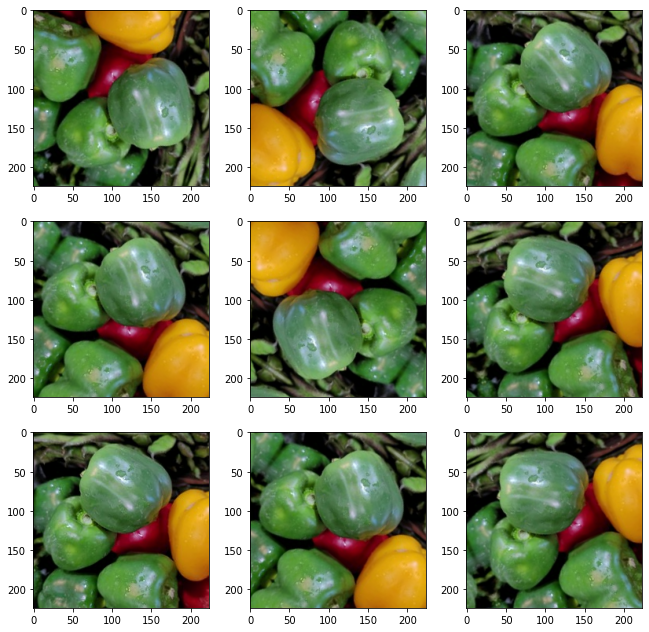

In [ ]:
plt.figure(figsize = (11, 11))
for img, labels in train_data.take(1):
  print(class_names[argmax(labels[i])])
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augment(img[0]).numpy().astype("uint8"))


# V 1.2 - Data augmentation

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.1),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(15, activation="softmax"),
    ]
)
print("Number of parameters :", model.count_params())

Number of parameters : 19203759


In [ ]:
batch_size = 128
epochs = 100
learning_rate = 0.0001
patience = 7

history = model_training(model, batch_size, epochs, learning_rate, patience)

Epoch 1/100
94/94 [==============================] - 35s 355ms/step - loss: 3.1091 - accuracy: 0.2197 - val_loss: 1.9361 - val_accuracy: 0.3423
Epoch 2/100
94/94 [==============================] - 33s 352ms/step - loss: 1.6126 - accuracy: 0.4540 - val_loss: 1.4206 - val_accuracy: 0.5243
Epoch 3/100
94/94 [==============================] - 33s 351ms/step - loss: 1.3055 - accuracy: 0.5430 - val_loss: 1.2017 - val_accuracy: 0.6007
Epoch 4/100
94/94 [==============================] - 33s 353ms/step - loss: 1.0640 - accuracy: 0.6350 - val_loss: 1.0081 - val_accuracy: 0.6517
Epoch 5/100
94/94 [==============================] - 33s 351ms/step - loss: 0.9185 - accuracy: 0.6883 - val_loss: 0.8809 - val_accuracy: 0.7097
Epoch 6/100
94/94 [==============================] - 33s 351ms/step - loss: 0.7819 - accuracy: 0.7427 - val_loss: 0.9422 - val_accuracy: 0.6883
Epoch 7/100
94/94 [==============================] - 33s 351ms/step - loss: 0.7009 - accuracy: 0.7623 - val_loss: 0.8592 - val_accuracy:

Loss :  0.38206
Accuracy :  0.887


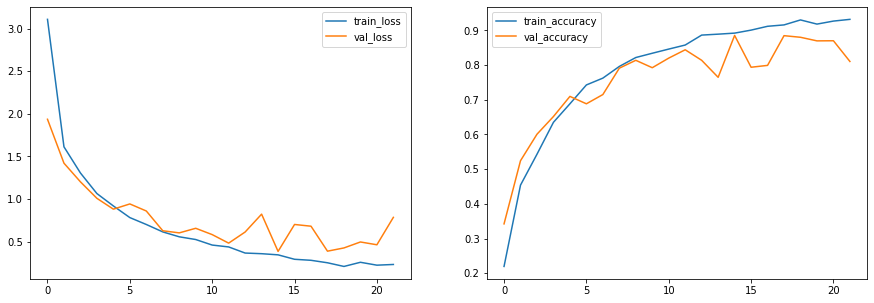

In [ ]:
plot_lr_score(history, model, test_data, class_names)

In [ ]:
model.save("/content/drive/MyDrive/vegetables/models/V_1_2.h5")

# V 1.3 - Add final Conv layer

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(15, activation="softmax"),
    ]
)
print("Number of parameters :", model.count_params())

Number of parameters : 4200047


In [ ]:
batch_size = 128
epochs = 100
learning_rate = 0.0001
patience = 7

history = model_training(model, batch_size, epochs, learning_rate, patience)

Epoch 1/100
94/94 [==============================] - 31s 318ms/step - loss: 2.5665 - accuracy: 0.1697 - val_loss: 2.2264 - val_accuracy: 0.2783
Epoch 2/100
94/94 [==============================] - 30s 315ms/step - loss: 1.9293 - accuracy: 0.3607 - val_loss: 1.4779 - val_accuracy: 0.5020
Epoch 3/100
94/94 [==============================] - 30s 317ms/step - loss: 1.5018 - accuracy: 0.4873 - val_loss: 1.3833 - val_accuracy: 0.5243
Epoch 4/100
94/94 [==============================] - 30s 316ms/step - loss: 1.2213 - accuracy: 0.5837 - val_loss: 1.1192 - val_accuracy: 0.5987
Epoch 5/100
94/94 [==============================] - 30s 316ms/step - loss: 1.0331 - accuracy: 0.6350 - val_loss: 0.9318 - val_accuracy: 0.6707
Epoch 6/100
94/94 [==============================] - 30s 317ms/step - loss: 0.9092 - accuracy: 0.6877 - val_loss: 0.9753 - val_accuracy: 0.6640
Epoch 7/100
94/94 [==============================] - 30s 316ms/step - loss: 0.7611 - accuracy: 0.7540 - val_loss: 0.9357 - val_accuracy:

Loss :  0.29469
Accuracy :  0.9188


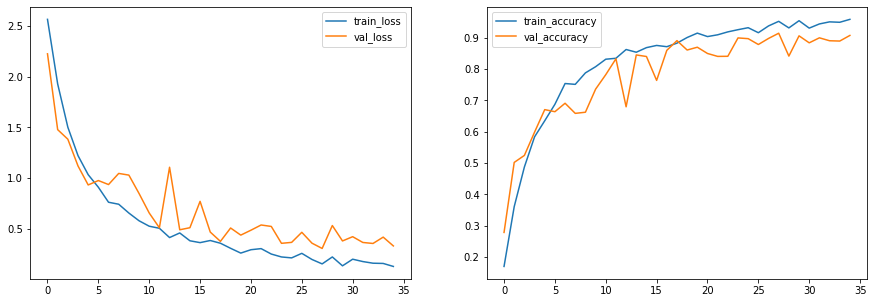

In [ ]:
plot_lr_score(history, model, test_data, class_names)

In [ ]:
model.save("/content/drive/MyDrive/vegetables/models/V_1_3.h5")

# V 1.3.5 - Tweaking parameters + Normalize images

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Normalization(),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.25),
        layers.Dense(256, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(15, activation="softmax"),
    ]
)
print("Number of parameters :", model.count_params())

Number of parameters : 4144694


In [ ]:
batch_size = 32
epochs = 100
learning_rate = 0.0001
patience = 7

history = model_training(model, batch_size, epochs, learning_rate, patience)

Epoch 1/100
469/469 [==============================] - 111s 227ms/step - loss: 1.6159 - accuracy: 0.4576 - val_loss: 1.2372 - val_accuracy: 0.5627
Epoch 2/100
469/469 [==============================] - 103s 219ms/step - loss: 0.8350 - accuracy: 0.7240 - val_loss: 0.6403 - val_accuracy: 0.7740
Epoch 3/100
469/469 [==============================] - 102s 217ms/step - loss: 0.5655 - accuracy: 0.8155 - val_loss: 0.5508 - val_accuracy: 0.8083
Epoch 4/100
469/469 [==============================] - 102s 216ms/step - loss: 0.4122 - accuracy: 0.8681 - val_loss: 0.4505 - val_accuracy: 0.8463
Epoch 5/100
469/469 [==============================] - 101s 216ms/step - loss: 0.3488 - accuracy: 0.8883 - val_loss: 0.3739 - val_accuracy: 0.8717
Epoch 6/100
469/469 [==============================] - 101s 214ms/step - loss: 0.2743 - accuracy: 0.9116 - val_loss: 0.2756 - val_accuracy: 0.9067
Epoch 7/100
469/469 [==============================] - 101s 215ms/step - loss: 0.2509 - accuracy: 0.9196 - val_loss: 0

Loss :  0.08685
Accuracy :  0.97067


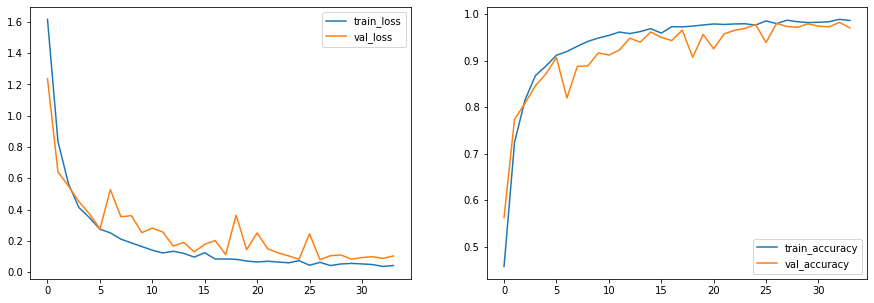

In [ ]:
plot_lr_score(history, model, test_data, class_names)

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/vegetables/models/V_2_0.h5")

# VGG

In [12]:
vgg = keras.applications.VGG16(
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    include_top = False)
for layer in vgg.layers:
  layer.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [13]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

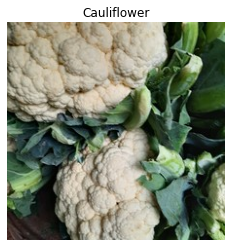

In [24]:
for img, labels in test_data.take(1):
  sample_image = img[0]
  sample_label = class_names[argmax(labels[0])]
plt.axis("off")
plt.title(sample_label)
plt.imshow(sample_image.numpy().astype("uint8"))

In [25]:
indexes = [1, 2]
for i in indexes:
  conv = keras.Model(inputs=vgg.input , outputs=vgg.layers[i].output)
  features = conv(tf.expand_dims(sample_image, 0))
  n_layers = features.shape[-1]
  plt.figure(figsize=(n_layers / 2, n_layers / 2))
  for j in range(n_layers):
    dim = np.sqrt(n_layers) + 1
    plt.subplot(dim, dim, j+1)
    plt.axis("off")
    plt.imshow(features[0, :, :, j])
  plt.savefig(f"/content/drive/MyDrive/vegetables/img/{sample_label}_conv{i}", dpi="figure", format="jpg")

Output hidden; open in https://colab.research.google.com to view.

# V 3.0 - Transfer learning

In [ ]:
out = vgg.output
out = layers.Flatten()(out)
out = layers.Dropout(0.25)(out)
out = layers.Dense(256, activation='relu')(out)
out = layers.Dense(64, activation='relu')(out)
out = layers.Dense(64, activation='relu')(out)
out = layers.Dense(15, activation="softmax")(out)
model = keras.Model(inputs=vgg.input, outputs=out)

print("Number of parameters :", model.count_params())

batch_size = 128
epochs = 100
learning_rate = 0.00001
patience = 5

history = model_training(model, batch_size, epochs, learning_rate, patience)

Number of parameters : 21159055
Epoch 1/100
469/469 [==============================] - 78s 163ms/step - loss: 3.6908 - accuracy: 0.4173 - val_loss: 0.7972 - val_accuracy: 0.7797
Epoch 2/100
469/469 [==============================] - 77s 164ms/step - loss: 0.7544 - accuracy: 0.8041 - val_loss: 0.3249 - val_accuracy: 0.9183
Epoch 3/100
469/469 [==============================] - 77s 163ms/step - loss: 0.3216 - accuracy: 0.9120 - val_loss: 0.1965 - val_accuracy: 0.9523
Epoch 4/100
469/469 [==============================] - 76s 163ms/step - loss: 0.1757 - accuracy: 0.9513 - val_loss: 0.1437 - val_accuracy: 0.9687
Epoch 5/100
469/469 [==============================] - 76s 163ms/step - loss: 0.0947 - accuracy: 0.9723 - val_loss: 0.1127 - val_accuracy: 0.9760
Epoch 6/100
469/469 [==============================] - 77s 163ms/step - loss: 0.0594 - accuracy: 0.9824 - val_loss: 0.0979 - val_accuracy: 0.9793
Epoch 7/100
469/469 [==============================] - 77s 163ms/step - loss: 0.0349 - accur

Loss :  0.03493
Accuracy :  0.99233


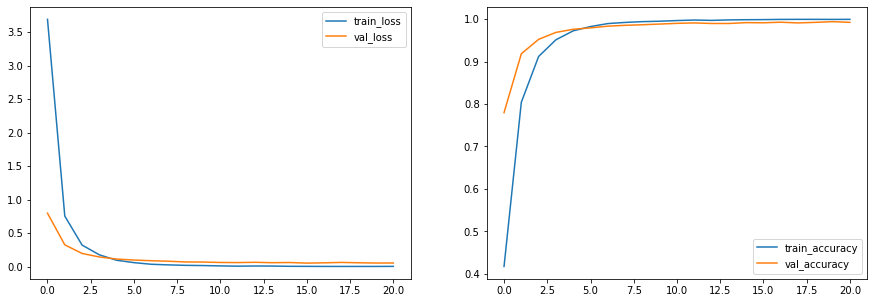

In [ ]:
plot_lr_score(history, model, test_data, class_names)

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/vegetables/models/V_3_0.h5")